In [1]:
file_id = '18Wx4PmuM3A4L3cpeEzM71WZf4HybVJ3o'  # замените на ваш идентификатор файла
file_name = 'hack.zip'  # замените на желаемое имя файла и расширение

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={file_id}' -O {file_name}


--2024-06-10 09:37:27--  https://docs.google.com/uc?export=download&id=18Wx4PmuM3A4L3cpeEzM71WZf4HybVJ3o
Resolving docs.google.com (docs.google.com)... 172.217.12.14, 2607:f8b0:4025:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=18Wx4PmuM3A4L3cpeEzM71WZf4HybVJ3o&export=download [following]
--2024-06-10 09:37:27--  https://drive.usercontent.google.com/download?id=18Wx4PmuM3A4L3cpeEzM71WZf4HybVJ3o&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.65.97, 2607:f8b0:4025:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.65.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182842 (179K) [application/octet-stream]
Saving to: ‘hack.zip’

hack.zip            100%[===================>] 178.56K  --.-KB/s    in 0.04s   

2024-06-

In [2]:
!unzip hack.zip

Archive:  hack.zip
  inflating: 9. ДЗМ/Количество исследований за месяц (для проверки).xlsx  
  inflating: 9. ДЗМ/Количество исследований по неделям (для реализации).xlsx  
  inflating: 9. ДЗМ/Нормативы РЦ.xlsx  
  inflating: 9. ДЗМ/Пример табеля с количеством врачей в разрезе модальностей и доп модальностей.xlsx  
  inflating: 9. ДЗМ/Шаблон для заполнения проверки по прогнозу за Февраль.xlsx  


In [3]:
# prompt: создай пять dataframe по каждому файлу xlsx которые лежат в 9. ДЗМ

import pandas as pd
import os

# Создаем словарь для хранения датафреймов
df_dict = {}

# Перебираем файлы в папке 9. ДЗМ
for file_name in os.listdir('9. ДЗМ'):
  # Проверяем, что файл имеет расширение xlsx
  if file_name.endswith('.xlsx'):
    # Читаем файл xlsx и сохраняем его в словаре
    df_dict[file_name] = pd.read_excel(os.path.join('9. ДЗМ', file_name))




In [4]:
for name, table in df_dict.items():
  print("_______________________________")
  print(name)
  print(table.head())
  print("_______________________________")

_______________________________
Нормативы РЦ.xlsx
  Наименование исследования Количество УЕ в одном описании  \
0                       NaN                            NaN   
1                        КТ                          11.58   
2                       МРТ                          15.06   
3                        РГ                           3.67   
4                       ФЛГ                              1   

                                Исследования без КУ*  \
0  Минимальное количество исследований за смену шт.    
1                                               15.6   
2                                                 12   
3                                               49.2   
4                                                181   

                                          Unnamed: 3  \
0  Минимальное количество УЕ за смену шт. округле...   
1                                                181   
2                                                181   
3               

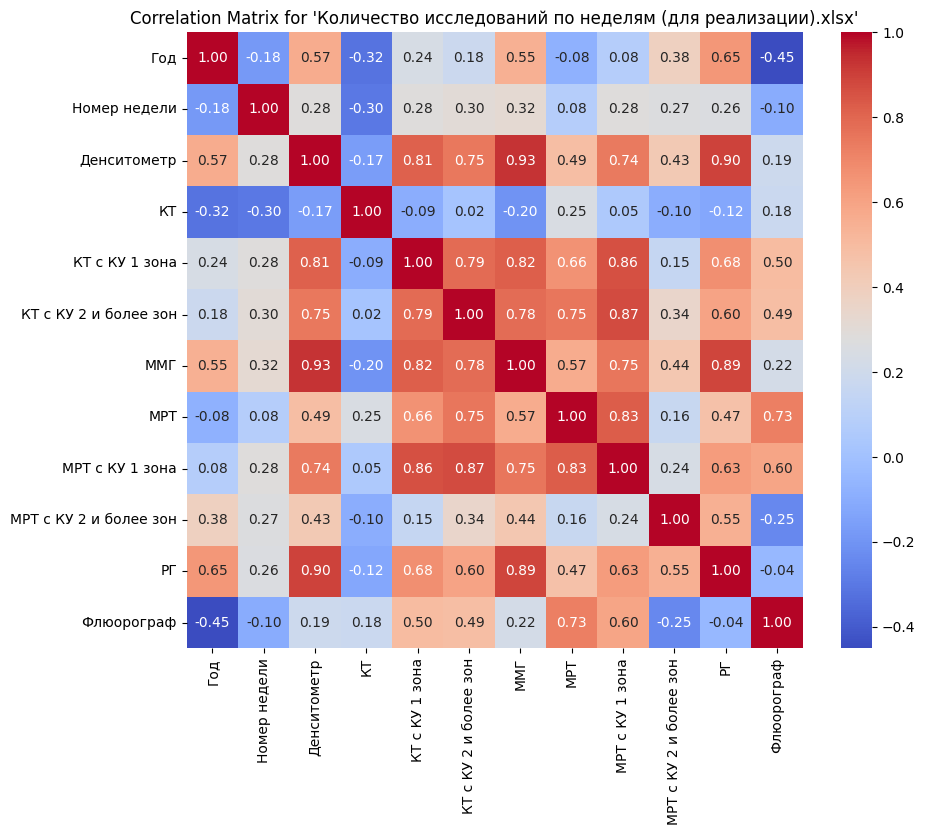

In [43]:
# prompt: построй коррелиационную матрицу и отрисуй ее для df_dict["Количество исследований по неделям (для реализации).xlsx"]

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_dict["Количество исследований по неделям (для реализации).xlsx"].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix for 'Количество исследований по неделям (для реализации).xlsx'")
plt.show()


In [46]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, dataframe, window_size, prev_weeks):
        self.data = dataframe
        self.window_size = window_size
        self.prev_weeks = prev_weeks

        # Удаление строк с NaN значениями (в конце)
        self.data.dropna(inplace=True)

        # Создание входных и выходных переменных
        self.X, self.y = self.create_sequences_old()

    def create_sequences_old(self):
        X, y = [], []
        for i in range(len(self.data) - self.window_size - 1):
            X.append(self.data.iloc[i:i+self.window_size, :12].values)
            y.append(self.data.iloc[i+self.window_size, 2:12].values)
        return np.array(X), np.array(y)

    def create_sequences(self):
        X, y = [], []
        for i in range(52, len(self.data) - self.window_size - 2):
            print(i + self.window_size - 1 - (52 + self.prev_weeks // 2 + 1), i + self.window_size - 1 - (52 - self.prev_weeks // 2))
            _1 = self.data.iloc[i:i+self.window_size, :12].values
            _2 = self.data.iloc[i + self.window_size - (52 + self.prev_weeks // 2): i + self.window_size - (52 - self.prev_weeks // 2) , :12].values
            print(_2.shape)
            print(_1.shape)
            X.append(np.concatenate((_1, _2), axis=0))
            # _1 = self.data.iloc[i+self.window_size-1, :2]
            # _2 = self.data.iloc[i+self.window_size-1, 12:].values
            # y.append(np.concatenate((_1, _2), axis=0))
            y.append(self.data.iloc[i+self.window_size-1, 12:].values)
        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

# Параметры окна и сдвига
window_size = 5
prev_weeks = 5

# Создание набора данных
df = df_dict["Количество исследований по неделям (для реализации).xlsx"].copy()
dataset = CustomDataset(df, window_size=window_size, prev_weeks=prev_weeks)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Создание DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Проверка работы DataLoader
for X_batch, y_batch in train_loader:
    print('X_batch:', X_batch)
    print('y_batch:', y_batch)
    break

X_batch: tensor([[[2.0220e+03, 7.0000e+00, 6.3700e+02, 8.4430e+03, 2.9500e+02,
          5.1400e+02, 7.7750e+03, 2.1350e+03, 6.8800e+02, 7.0000e+00,
          4.1694e+04, 1.8370e+04],
         [2.0220e+03, 8.0000e+00, 5.5600e+02, 5.8490e+03, 2.6500e+02,
          5.4100e+02, 7.7060e+03, 2.0230e+03, 6.8300e+02, 3.0000e+00,
          3.7030e+04, 1.9250e+04],
         [2.0220e+03, 9.0000e+00, 1.0500e+03, 5.8510e+03, 4.7600e+02,
          6.6900e+02, 1.1323e+04, 2.3180e+03, 8.5200e+02, 7.0000e+00,
          5.1042e+04, 2.9023e+04],
         [2.0220e+03, 1.0000e+01, 6.9100e+02, 4.5360e+03, 2.9500e+02,
          4.3100e+02, 7.3520e+03, 1.6020e+03, 6.1900e+02, 5.0000e+00,
          3.4205e+04, 1.7540e+04],
         [2.0220e+03, 1.1000e+01, 1.2090e+03, 5.9010e+03, 5.1500e+02,
          7.1500e+02, 1.1553e+04, 2.2720e+03, 8.5300e+02, 1.1000e+01,
          4.9459e+04, 2.9958e+04]],

        [[2.0230e+03, 3.0000e+01, 1.4990e+03, 4.1250e+03, 6.2100e+02,
          7.6500e+02, 1.5390e+04, 2.0330e+03

In [47]:
for X, y in train_loader:
  print(X.shape)
  print(y.shape)
  break

torch.Size([2, 5, 12])
torch.Size([2, 10])


In [48]:
import torch.nn as nn
import torch.optim as optim

def cosine_distance(tensor1, tensor2):
    """
    Вычисляет косинусное расстояние между двумя тензорами.

    Args:
    tensor1 (torch.Tensor): Первый тензор.
    tensor2 (torch.Tensor): Второй тензор.

    Returns:
    float: Косинусное расстояние между двумя тензорами.
    """
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    return 1 - cos(tensor1, tensor2)


class CustomHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CustomHuberLoss, self).__init__()
        self.delta = delta

    def forward(self, outputs, targets):
        huber_loss = torch.where(
            torch.abs(outputs - targets) < self.delta,
            0.5 * (outputs - targets) ** 2,
            self.delta * (torch.abs(outputs - targets) - 0.5 * self.delta)
        )
        penalty = torch.sum(torch.relu(-outputs))  # штраф за отрицательные значения
        return torch.mean(huber_loss) + penalty

# Определение модели нейронной сети
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def custom_loss(outputs, targets):
    mse_loss = nn.MSELoss()(outputs, targets)
    penalty = torch.sum(torch.relu(-outputs)) * 2 # штраф за отрицательные значения
    return mse_loss + penalty


# Параметры модели
# input_size = (window_size + prev_weeks - 1) * 12  # 10 наблюдений за каждую неделю в окне
input_size = window_size * 12  # 10 наблюдений за каждую неделю в окне
hidden_size = 20
output_size = 10  # количество целевых переменных

# Создание модели, функции потерь и оптимизатора
model = SimpleNN(input_size, hidden_size, output_size)
criterion = CustomHuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.015)

# Обучение модели
num_epochs = 150
best_model = None
best_loss = float('inf')
for epoch in range(num_epochs):
    test_loss = 0
    for X_batch, y_batch in train_loader:
        model.train()
        # Изменение формы X_batch для соответствия модели
        X_batch = X_batch.view(X_batch.size(0), -1)

        # Прямой проход
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            test_loss += criterion(outputs, y_batch)
        if test_loss < best_loss:
            best_model = model
            best_loss = test_loss
            print("Best Model in epoch:", epoch, "Loss:", test_loss)
            torch.save(model.state_dict(), "best.pt")
        torch.save(model.state_dict(), "last.pt")

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Проверка модели на обучающей выборке (пример)
best_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(X_batch.size(0), -1)
        outputs = best_model(X_batch)
        print('Predicted:', outputs)
        print('Actual:', y_batch)
        distance = cosine_distance(outputs, y_batch)
        print(f'Cosine Distance: {distance}')
        break


Best Model in epoch: 0 Loss: tensor(30031.0762)
Best Model in epoch: 1 Loss: tensor(25141.9805)
Best Model in epoch: 2 Loss: tensor(17281.2129)
Best Model in epoch: 9 Loss: tensor(16253.1367)
Epoch [10/150], Loss: 1689.5729
Epoch [20/150], Loss: 1636.7708
Best Model in epoch: 21 Loss: tensor(15744.6875)
Best Model in epoch: 24 Loss: tensor(15255.6230)
Best Model in epoch: 25 Loss: tensor(14492.8291)
Best Model in epoch: 26 Loss: tensor(12343.9473)
Best Model in epoch: 29 Loss: tensor(11153.9756)
Epoch [30/150], Loss: 1441.3232
Best Model in epoch: 32 Loss: tensor(10686.5537)
Epoch [40/150], Loss: 1077.6268
Epoch [50/150], Loss: 935.7910
Best Model in epoch: 50 Loss: tensor(10110.5938)
Epoch [60/150], Loss: 1574.6210
Epoch [70/150], Loss: 1377.7988
Epoch [80/150], Loss: 1765.2360
Epoch [90/150], Loss: 1704.4039
Epoch [100/150], Loss: 1968.1270
Epoch [110/150], Loss: 2416.8403
Epoch [120/150], Loss: 1346.5035
Epoch [130/150], Loss: 1200.0710
Epoch [140/150], Loss: 1474.6985
Epoch [150/15

KeyError: "['Количество наблюдений'] not found in axis"